In [1]:
import numpy as np
import sklearn
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2
import random

### GPU Available

In [2]:
import torch
print("GPU Available: ", torch.cuda.is_available()) 

GPU Available:  True


In [3]:
import torch
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

## Read in images

In [4]:
# Save tumour images in tumour list and healthy images in healthy list

tumour = []
healthy = []

path_yes = 'C:/Users/mahno/Documents/Self-Study/IndProjects/BrainTumour/data/yes/*.jpg'
# Iterate through path and save images as rgb
for f in glob.iglob(path_yes):
    img = cv2.imread(f)
    img = cv2.resize(img, (128,128))
    b,g,r = cv2.split(img)
    cv2.merge([r,g,b])
    tumour.append(img)


path_no = 'C:/Users/mahno/Documents/Self-Study/IndProjects/BrainTumour/data/yes/*.jpg'
# Iterate through path and save images as rgb
for f in glob.iglob(path_no):
    img = cv2.imread(f)
    img = cv2.resize(img, (128,128))
    b,g,r = cv2.split(img)
    cv2.merge([r,g,b])
    healthy.append(img)

In [5]:
# Check lengths
print(len(tumour))
print(len(healthy))

# Check size of images
#for img in tumour:
    #print(img.shape)

154
154


In [6]:
#Save healthy and tumourous images in array
healthy = np.array(healthy)
tumour = np.array(tumour)
all_imgs = np.concatenate((healthy, tumour))

In [7]:
healthy.shape
#healthy.shape[0]

(154, 128, 128, 3)

## Visualising Brain MRI Images

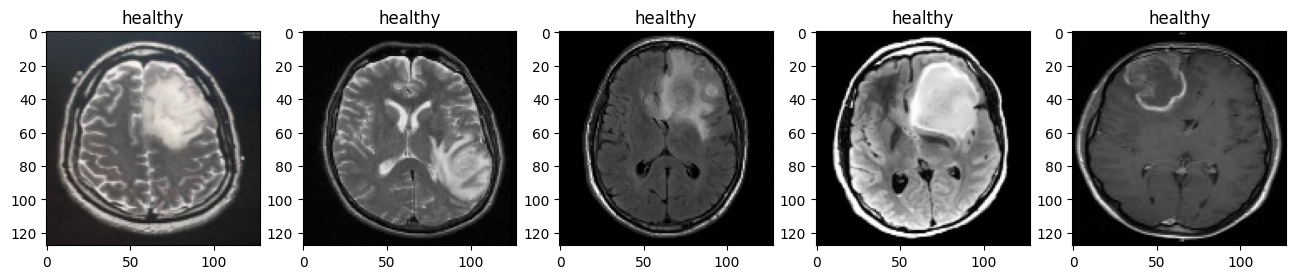

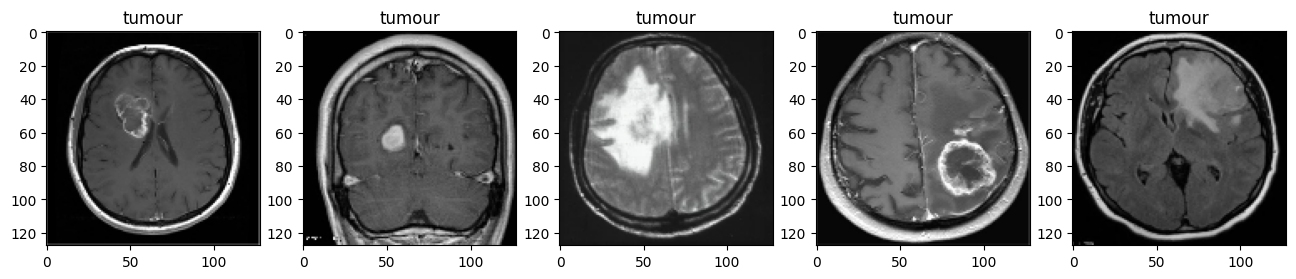

In [8]:
# Visualise random images from both datasets
def plot_random(healthy, tumour, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumour_imgs = tumour[np.random.choice(tumour.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num): 
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])


    plt.figure(figsize=(16,9))
    for i in range(num): 
        plt.subplot(1, num, i+1)
        plt.title('tumour')
        plt.imshow(tumour_imgs[i])


plot_random(healthy, tumour)

## Create MRI custom dataset class

In [9]:
# PyTorch class to deal with datasets inherits from PyTorch's abstract dataset class
# Create constructor; overwrite dunder methods
class MRI(Dataset):
    def __init__(self):
        # Load data from directories into numpy arrays
        tumour = []
        healthy = []
        path_yes = 'C:/Users/mahno/Documents/Self-Study/IndProjects/BrainTumour/data/yes/*.jpg'
        for f in glob.iglob(path_yes):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            tumour.append(img)
        
        path_no = 'C:/Users/mahno/Documents/Self-Study/IndProjects/BrainTumour/data/no/*.jpg'
        for f in glob.iglob(path_no):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            healthy.append(img)
            
        # Images 
        tumour = np.array(tumour, dtype=np.float32)
        healthy = np.array(healthy, dtype = np.float32)
            
        # Labels - 1's for number of tumours, 0's for number of healthy
        tumour_label = np.ones(tumour.shape[0], dtype = np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype = np.float32)
        
        # Concatenate as one array for images and one as labels of both tumour and healthy
        self.images = np.concatenate((tumour, healthy), axis=0)
        self.labels = np.concatenate((tumour_label, healthy_label))

    def __len__(self):
        # Get number of images
        return self.images.shape[0]
    
    def __getitem__(self, index):
        # Get image and label sample at index
        sample = {'image': self.images[index], 'label': self.labels[index]}
        return sample
    
    def normalize(self):
        # Normalise values of pixels between 0 and 1
        self.images = self.images/255.0



In [10]:
# Create instance
mri_dataset = MRI()
mri_dataset.normalize()

## Data Loader

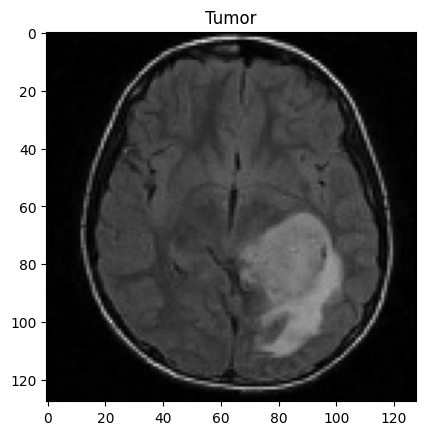

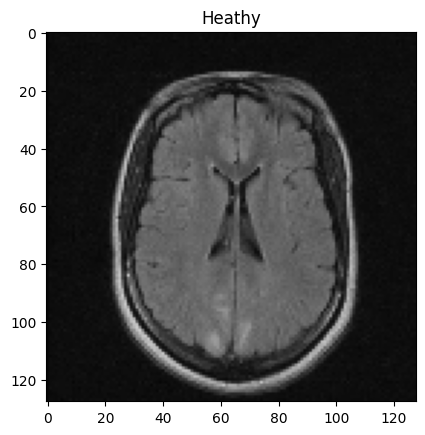

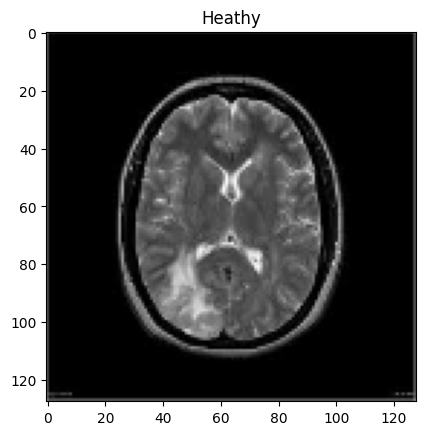

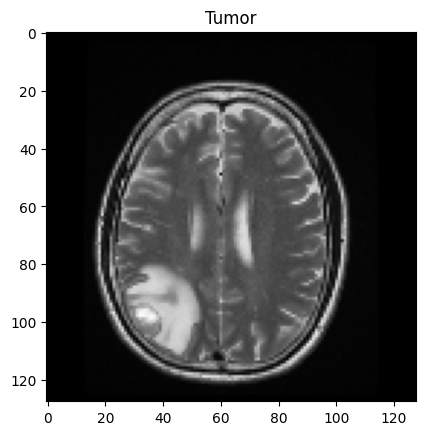

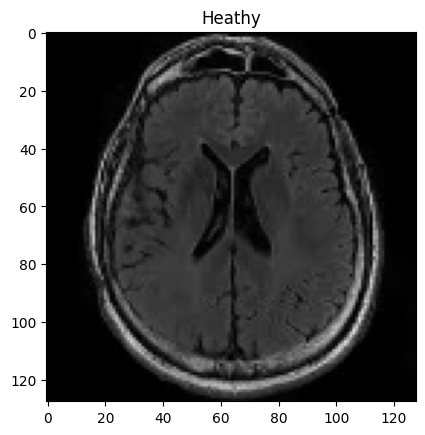

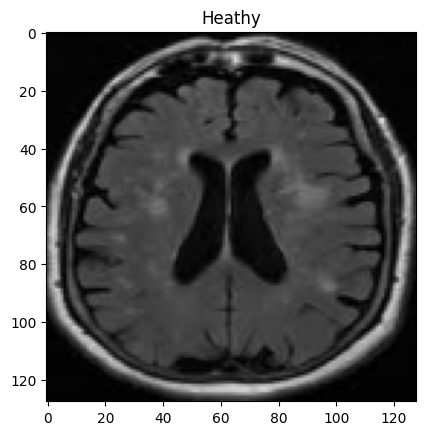

In [11]:
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

## Creating the model

In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
class CNN(nn.Module):
    def __init__(self):
        # Define sequence of layers and pass parameters, placed in one instance variable
        super(CNN,self).__init__()

        # In channels: first convolutional layer will have 3 channels (b/c it's the input image)
        # Out channels: define number of convolutional filters (kernels) in layer
        # and give size of each kernel.
        # Separate convolutional layers with commas
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            
        nn.Tanh(), # No learnable parameters, transform each array between -1 and 1

        # Done to each array/channel independently:
        # Pooling: defined kernel size slides across data and averages elements
        # Stride: jumps 5 by 5 and averages
        nn.AvgPool2d(kernel_size=2, stride=5), 

        # Second convolutional layer
        # Increase number of channels the deeper the network goes
        # Output of previous layer is input of next layer
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))

        # Fully connected layers, last layer for classification
        # One neuron to determine if it has tumour or not (binary classification)
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        # Create class out of it
        x = self.cnn_model(x)
        # Flatten 2D arrays (since we have linear layers after conv layers)
        x = x.view(x.size(0), -1)
        # Cast x into model
        x = self.fc_model(x)
        # Sigmoid unit to output 0 or 1
        x = F.sigmoid(x)
        
        return x
            

In [14]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

cuda
tensor([0.5718, 0.8325, 0.3878, 0.1171, 0.2900, 0.3311, 0.7178, 0.9962, 0.1539,
        0.2851], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([0.5718, 0.8325, 0.3878, 0.1171, 0.2900, 0.3311, 0.7178, 0.9962, 0.1539,
        0.2851], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([0.3270, 0.6931, 0.1504, 0.0137, 0.0841, 0.1096, 0.5152, 0.9925, 0.0237,
        0.0813], device='cuda:0')


In [15]:
device = torch.device('cuda:0')
model = CNN().to(device)

In [18]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [19]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
    

In [20]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [21]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [22]:
accuracy_score(y_true, threshold(outputs))

0.6326530612244898

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

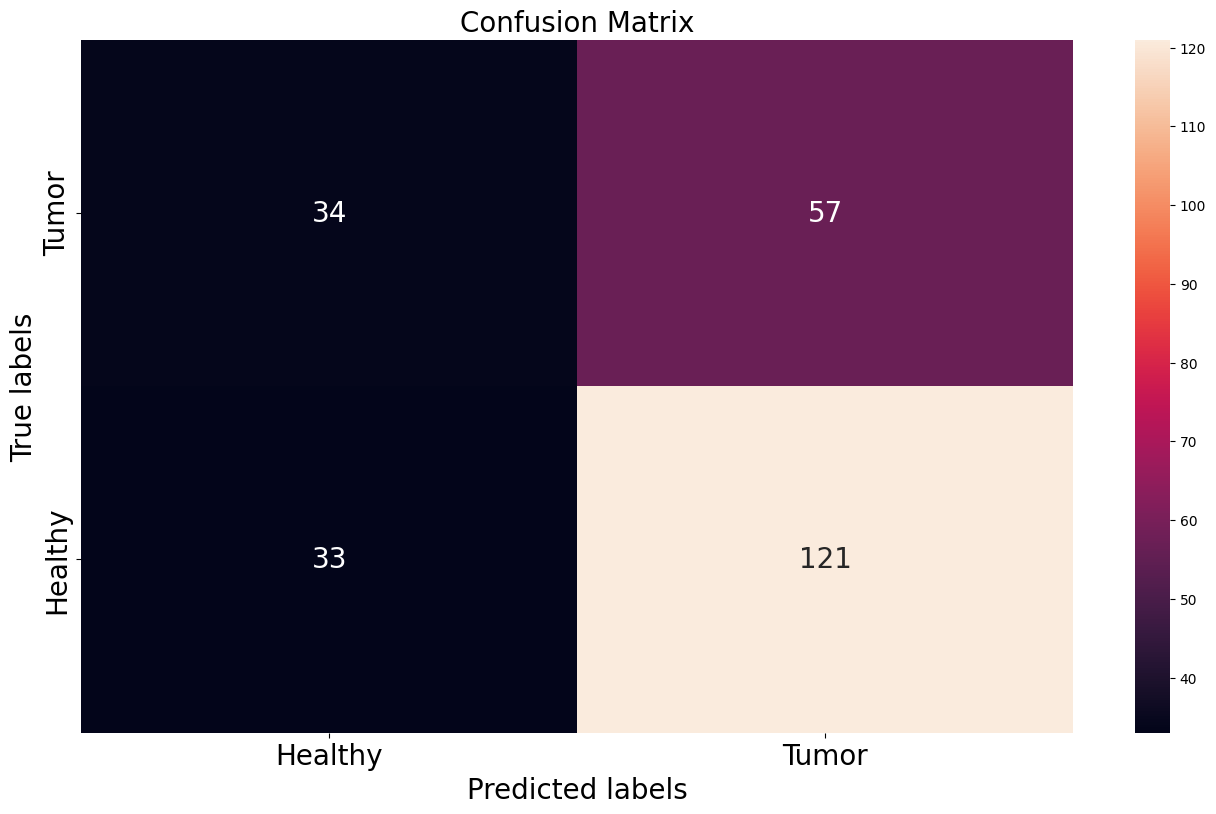

In [23]:
# a confusion matrix
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

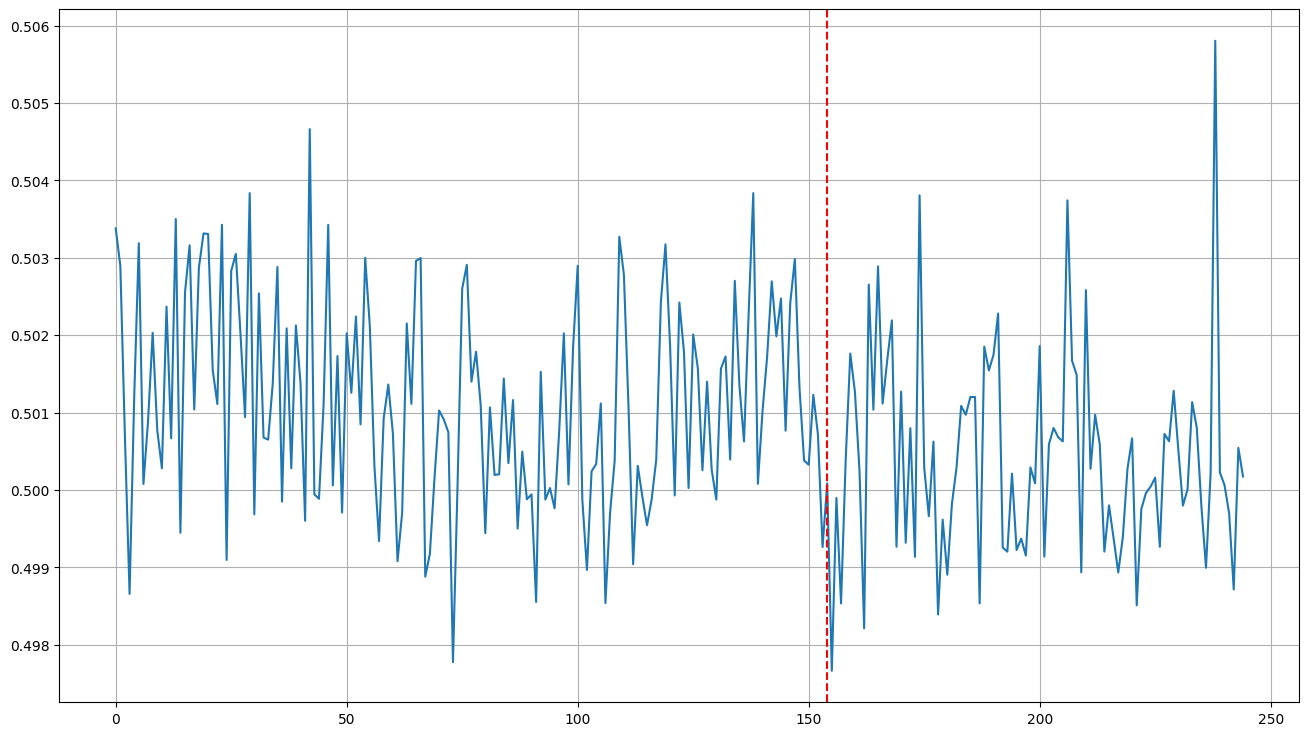

In [24]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumour), color='r', linestyle='--')
plt.grid()

## Training

In [25]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [26]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss() 
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.622452
Train Epoch: 20	Loss: 0.601960
Train Epoch: 30	Loss: 0.566386
Train Epoch: 40	Loss: 0.534874
Train Epoch: 50	Loss: 0.519138
Train Epoch: 60	Loss: 0.525903
Train Epoch: 70	Loss: 0.492446
Train Epoch: 80	Loss: 0.488527
Train Epoch: 90	Loss: 0.461515
Train Epoch: 100	Loss: 0.451464
Train Epoch: 110	Loss: 0.430026
Train Epoch: 120	Loss: 0.405437
Train Epoch: 130	Loss: 0.398702
Train Epoch: 140	Loss: 0.374284
Train Epoch: 150	Loss: 0.356427
Train Epoch: 160	Loss: 0.340155
Train Epoch: 170	Loss: 0.327523
Train Epoch: 180	Loss: 0.310729
Train Epoch: 190	Loss: 0.285170
Train Epoch: 200	Loss: 0.274125
Train Epoch: 210	Loss: 0.246220
Train Epoch: 220	Loss: 0.229177
Train Epoch: 230	Loss: 0.204012
Train Epoch: 240	Loss: 0.192051
Train Epoch: 250	Loss: 0.172332
Train Epoch: 260	Loss: 0.144534
Train Epoch: 270	Loss: 0.134872
Train Epoch: 280	Loss: 0.115183
Train Epoch: 290	Loss: 0.094993
Train Epoch: 300	Loss: 0.094398
Train Epoch: 310	Loss: 0.072175
Train Epoch: 320	

## Evaluate

In [27]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [28]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

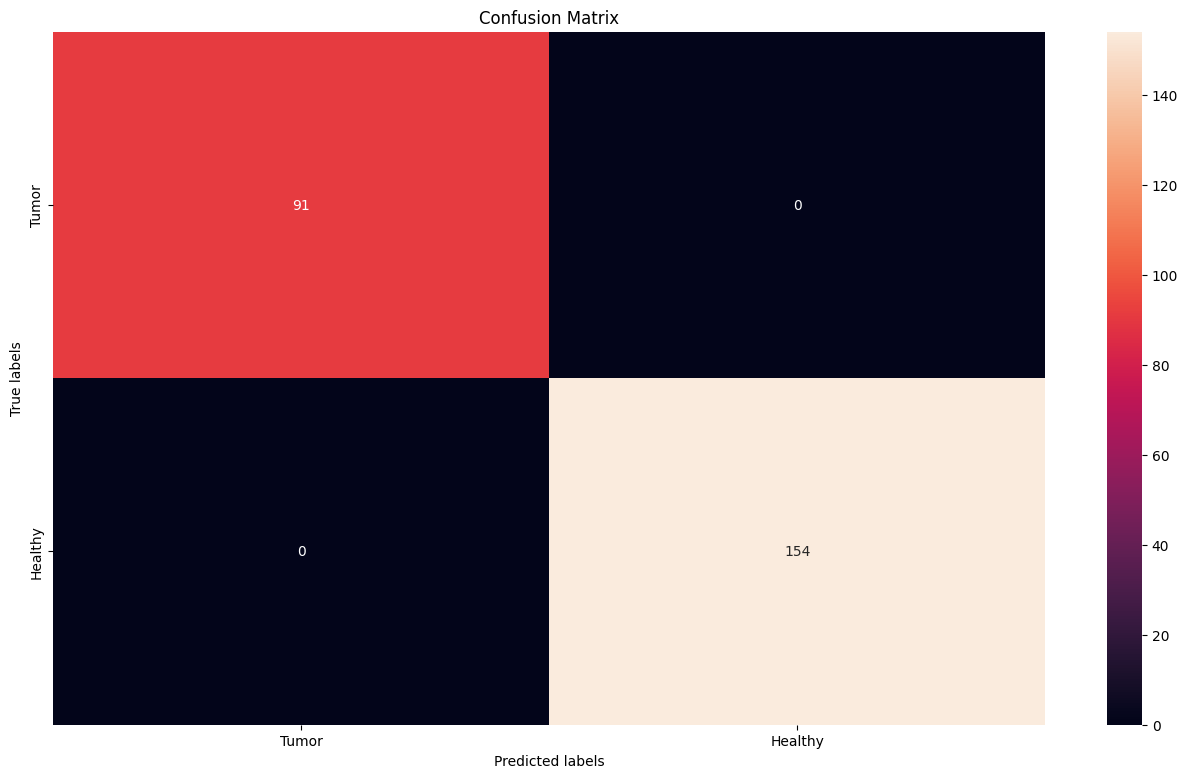

In [29]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

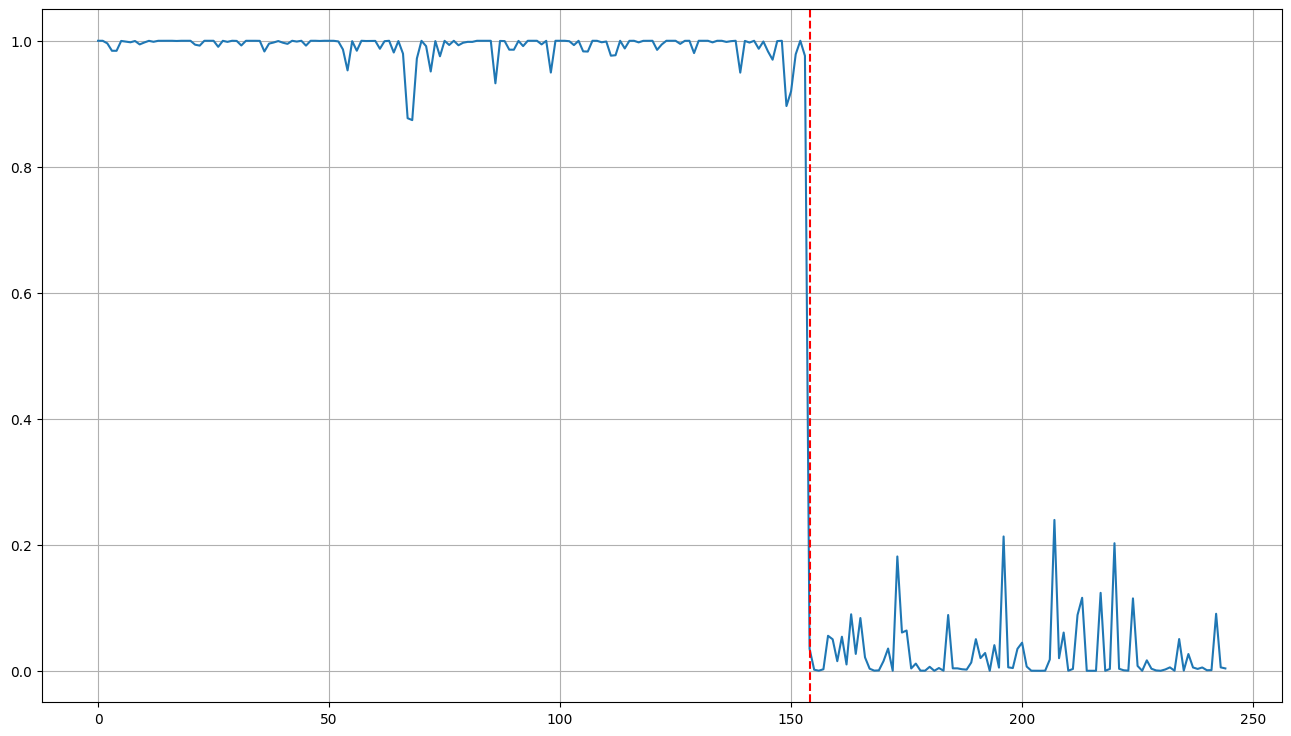

In [30]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumour), color='r', linestyle='--')
plt.grid()

## Check for Overfitting

In [31]:
# Import train/test split function from sklearn
from sklearn.model_selection import train_test_split

In [32]:
class MRI(Dataset):
    
    def __init__(self):
        
        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        
        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
    
    # Define a function that would separate the data into Training and Validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)
        
    def __len__(self):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
    
    def __getitem__(self, idx):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}
        
        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [33]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda:0")
model = CNN().to(device)

eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)



In [34]:
# keep track of epoch losses
epoch_train_loss = []
epoch_val_loss = []

In [35]:
for epoch in range(1,600):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    # validate for the current epoch
    val_losses = []
    model.eval()
    
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))
    

Train Epoch: 10	Train Loss: 0.632023	Val Loss: 0.610595
Train Epoch: 20	Train Loss: 0.626776	Val Loss: 0.600160
Train Epoch: 30	Train Loss: 0.609321	Val Loss: 0.577449
Train Epoch: 40	Train Loss: 0.609248	Val Loss: 0.564957
Train Epoch: 50	Train Loss: 0.553940	Val Loss: 0.572540
Train Epoch: 60	Train Loss: 0.490806	Val Loss: 0.601463
Train Epoch: 70	Train Loss: 0.452837	Val Loss: 0.638594
Train Epoch: 80	Train Loss: 0.472131	Val Loss: 0.671993
Train Epoch: 90	Train Loss: 0.449900	Val Loss: 0.686313
Train Epoch: 100	Train Loss: 0.430243	Val Loss: 0.700490
Train Epoch: 110	Train Loss: 0.428806	Val Loss: 0.703753
Train Epoch: 120	Train Loss: 0.349453	Val Loss: 0.695704
Train Epoch: 130	Train Loss: 0.361430	Val Loss: 0.722043
Train Epoch: 140	Train Loss: 0.312047	Val Loss: 0.727520
Train Epoch: 150	Train Loss: 0.338742	Val Loss: 0.694907
Train Epoch: 160	Train Loss: 0.312539	Val Loss: 0.693704
Train Epoch: 170	Train Loss: 0.376037	Val Loss: 0.718291
Train Epoch: 180	Train Loss: 0.238427	Va

Text(0, 0.5, 'Loss')

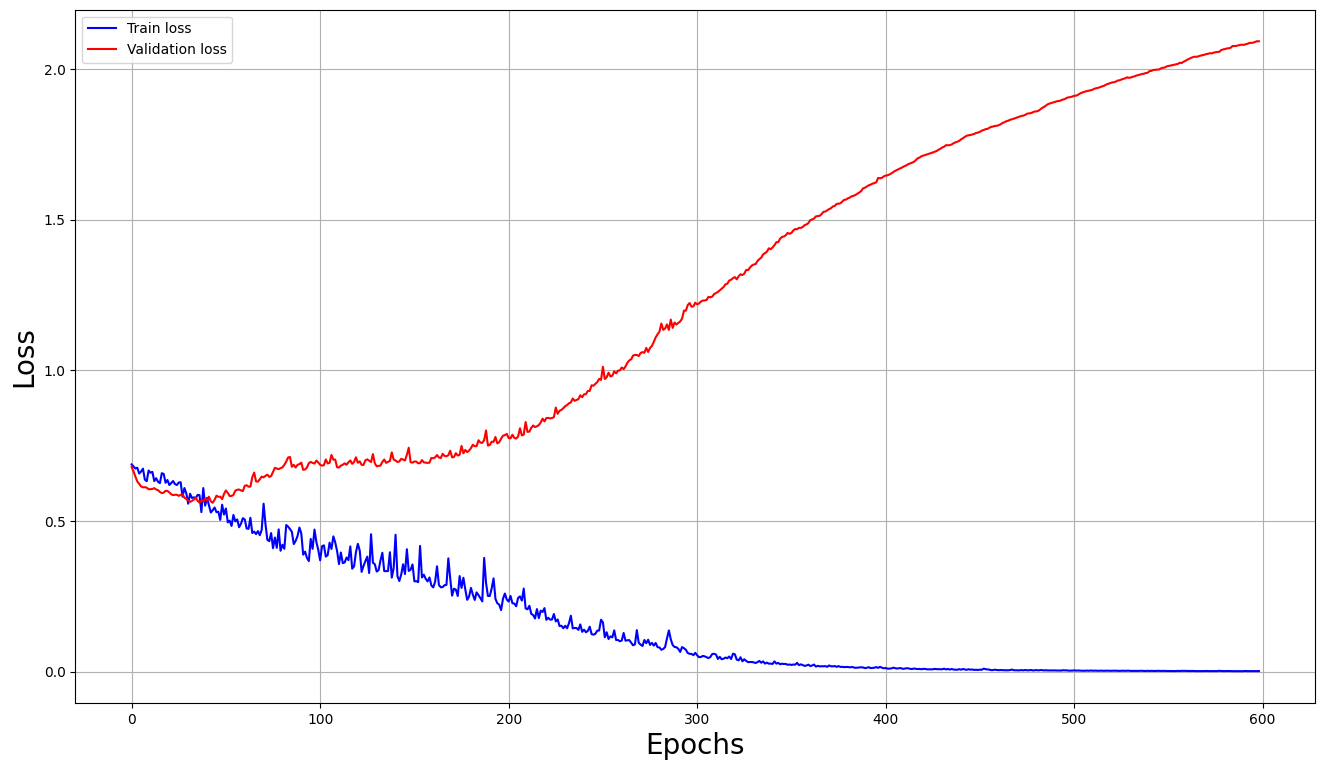

In [36]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)

## Correct for Overfitting
### Attempt 1
Overfitting is evident in previous plot - as training loss decreases, validation loss increases, meaning the model cannot fit to unseen data.
Attempts are made to fix this. We start by adding dropout layers, L2 regularisation (weight decay), reducing the learning rate and using batch normalisation.

In [43]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.BatchNorm2d(6),
            nn.AvgPool2d(kernel_size=2, stride=2),  # Adjust stride for better coverage
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.BatchNorm2d(16),
            nn.AvgPool2d(kernel_size=2, stride=2))
        
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=16 * 29 * 29, out_features=120),  # Updated input size
            nn.Tanh(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=84, out_features=1))

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)  # Flatten the output from the conv layers
        x = self.fc_model(x)
        x = torch.sigmoid(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

In [44]:
# Using GPU
print(device)

cuda


In [45]:
for epoch in range(1,600):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    # validate for the current epoch
    val_losses = []
    model.eval()
    
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))
    

Train Epoch: 10	Train Loss: 0.315510	Val Loss: 0.549249
Train Epoch: 20	Train Loss: 0.179385	Val Loss: 0.494295
Train Epoch: 30	Train Loss: 0.096555	Val Loss: 0.524720
Train Epoch: 40	Train Loss: 0.053453	Val Loss: 0.536371
Train Epoch: 50	Train Loss: 0.028475	Val Loss: 0.613972
Train Epoch: 60	Train Loss: 0.036994	Val Loss: 0.676406
Train Epoch: 70	Train Loss: 0.018238	Val Loss: 0.721932
Train Epoch: 80	Train Loss: 0.018801	Val Loss: 0.742551
Train Epoch: 90	Train Loss: 0.009187	Val Loss: 0.779667
Train Epoch: 100	Train Loss: 0.008209	Val Loss: 0.798211
Train Epoch: 110	Train Loss: 0.021399	Val Loss: 0.833789
Train Epoch: 120	Train Loss: 0.007940	Val Loss: 0.842407
Train Epoch: 130	Train Loss: 0.005789	Val Loss: 0.863314
Train Epoch: 140	Train Loss: 0.006648	Val Loss: 0.884006
Train Epoch: 150	Train Loss: 0.013099	Val Loss: 0.908868
Train Epoch: 160	Train Loss: 0.004427	Val Loss: 0.956522
Train Epoch: 170	Train Loss: 0.002879	Val Loss: 0.958091
Train Epoch: 180	Train Loss: 0.004603	Va

This results in little improvement in the loss. 

### Attempt 2
The dropout is then increased, as is weight decay. Learning rate scheduling is also incorportated to reduce the learning rate during training, which can help the model converge better to avoid overfitting. Early stopping is also included, which monitors the validation loss and stops the training when it stops improving. This is quickly removed again, however, due to the oscillation of the validation loss (which resulted in TOO early stopping).

In [47]:
from torch import nn, optim
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.BatchNorm2d(6),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.BatchNorm2d(16),
            nn.AvgPool2d(kernel_size=2, stride=2))
        
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=16 * 29 * 29, out_features=120),
            nn.Tanh(),
            nn.Dropout(p=0.6),  # Increased dropout
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Dropout(p=0.6),  # Increased dropout
            nn.Linear(in_features=84, out_features=1))

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = torch.sigmoid(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Increased weight decay
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

best_val_loss = float('inf')
patience = 10
patience_counter = 0



In [48]:
for epoch in range(1, 600):
    model.train()
    train_losses = []
    mri_dataset.mode = 'train'
    
    for D in train_dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        error = nn.BCELoss()
        loss = error(y_hat.squeeze(), label)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss = np.mean(train_losses)
    
    model.eval()
    val_losses = []
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = error(y_hat.squeeze(), label)
            val_losses.append(loss.item())
    
    epoch_val_loss = np.mean(val_losses)
    scheduler.step(epoch_val_loss)
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping")
        break
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}')

Epoch 10, Train Loss: 0.383772, Val Loss: 0.552515
Early stopping


In [49]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=256 * 8 * 8, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=128, out_features=1)
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x  # Remove sigmoid here

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Reduced learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Use BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()

In [50]:
num_epochs = 600
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    mri_dataset.mode = 'train'
    
    for D in train_dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        loss = criterion(y_hat.squeeze(), label)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    model.eval()
    val_losses = []
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            loss = criterion(y_hat.squeeze(), label)
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    scheduler.step(epoch_val_loss[-1])
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss[-1]:.6f}, Val Loss: {epoch_val_loss[-1]:.6f}')

Epoch 10, Train Loss: 0.113241, Val Loss: 0.564745
Epoch 20, Train Loss: 0.020617, Val Loss: 0.790266
Epoch 30, Train Loss: 0.009638, Val Loss: 0.847291
Epoch 40, Train Loss: 0.011693, Val Loss: 0.897142
Epoch 50, Train Loss: 0.004838, Val Loss: 0.903504
Epoch 60, Train Loss: 0.009124, Val Loss: 0.910511
Epoch 70, Train Loss: 0.007169, Val Loss: 0.926756
Epoch 80, Train Loss: 0.004675, Val Loss: 0.887279
Epoch 90, Train Loss: 0.015649, Val Loss: 0.926257
Epoch 100, Train Loss: 0.010066, Val Loss: 0.925341
Epoch 110, Train Loss: 0.008481, Val Loss: 0.915374


KeyboardInterrupt: 

At this point it is evident that this model cannot learn without overfitting. Therefore, an attempt is made to use pretrained models, which are advantageous due to their deeper architectures.

## ResNet50
The pretrained ResNet50 model is incorporated as it has a deep architecture, which could help the overfitting problem.
The pretrained model is loaded from torchvision models and the final layers are modified to fit the binary classification task. The training loop is also adjusted to use the pretrained model.

In [57]:
class ResNet50Model(nn.Module):
    def __init__(self):
        super(ResNet50Model, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        # Replace the final fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.resnet(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet50Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Use BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()

In [59]:
num_epochs = 600
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    mri_dataset.mode = 'train'
    
    for D in train_dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        loss = criterion(y_hat.squeeze(), label)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    model.eval()
    val_losses = []
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            loss = criterion(y_hat.squeeze(), label)
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    scheduler.step(epoch_val_loss[-1])
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss[-1]:.6f}, Val Loss: {epoch_val_loss[-1]:.6f}')

Epoch 10, Train Loss: 0.117856, Val Loss: 0.746457
Epoch 20, Train Loss: 0.022153, Val Loss: 0.954046
Epoch 30, Train Loss: 0.010258, Val Loss: 0.848387
Epoch 40, Train Loss: 0.027604, Val Loss: 0.850864
Epoch 50, Train Loss: 0.012708, Val Loss: 0.843707
Epoch 60, Train Loss: 0.014711, Val Loss: 0.810803
Epoch 70, Train Loss: 0.029893, Val Loss: 0.830313
Epoch 80, Train Loss: 0.012506, Val Loss: 0.816312
Epoch 90, Train Loss: 0.237132, Val Loss: 0.837875
Epoch 100, Train Loss: 0.012233, Val Loss: 0.839662
Epoch 110, Train Loss: 0.013018, Val Loss: 0.845818
Epoch 120, Train Loss: 0.010466, Val Loss: 0.817512
Epoch 130, Train Loss: 0.025267, Val Loss: 0.813810
Epoch 140, Train Loss: 0.037537, Val Loss: 0.794232
Epoch 150, Train Loss: 0.011700, Val Loss: 0.807881
Epoch 160, Train Loss: 0.021607, Val Loss: 0.828170
Epoch 170, Train Loss: 0.140578, Val Loss: 0.831879
Epoch 180, Train Loss: 0.010947, Val Loss: 0.841509
Epoch 190, Train Loss: 0.021711, Val Loss: 0.773736
Epoch 200, Train Loss

Text(0, 0.5, 'Loss')

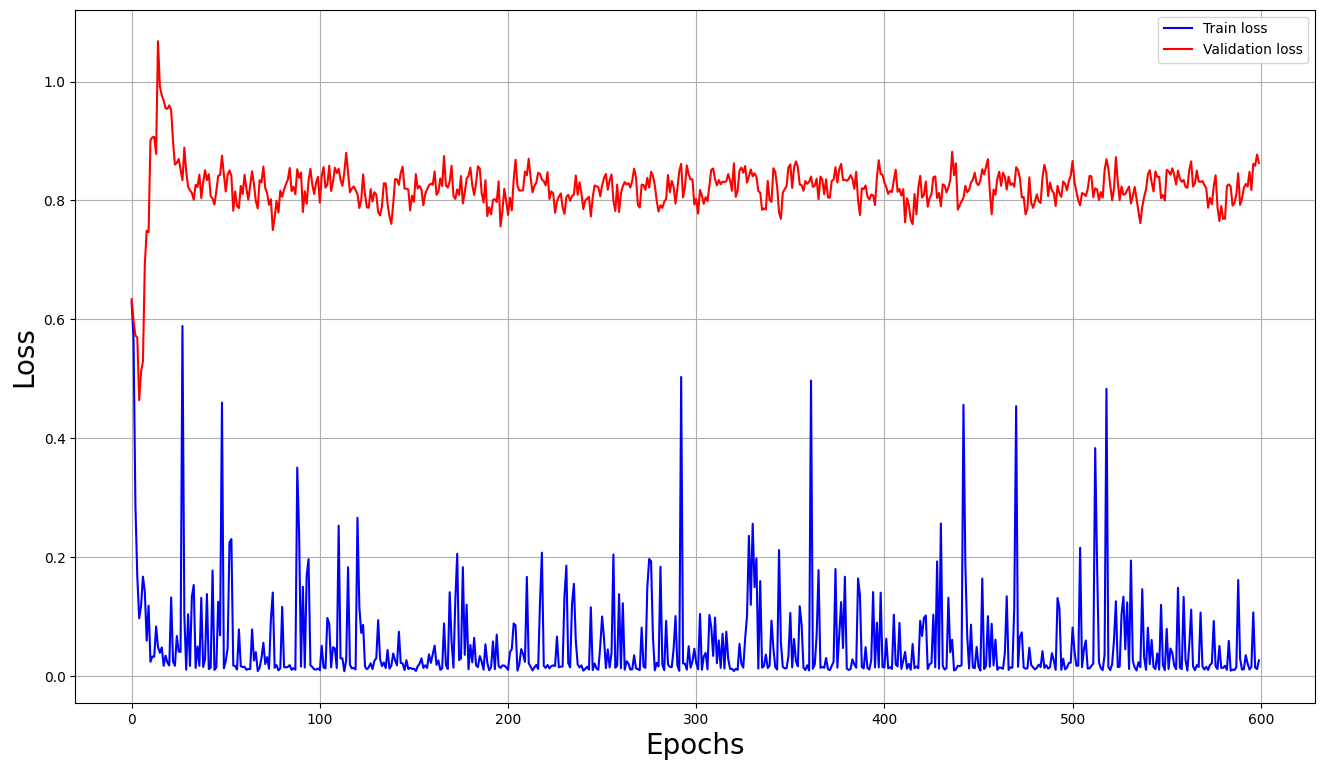

In [60]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)

This model does not lead to much improvement, which could be because our dataset is small while the ResNet50 architecture is too deep. Therefore, a smaller model may be more suited as a simpler architecture could reduce overfitting since our dataset is not so large.

While there is not much improvement in the loss, it is much more stable and does not seem to increase with every epoch, which is something we saw in the trainings of the previous models.

## ResNet 18
The ResNet18 is a smaller pretrained model than the ResNet50, which may be more suited to our small dataset.

In [62]:
class ResNet18Model(nn.Module):
    def __init__(self):
        super(ResNet18Model, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        # Replace the final fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.resnet(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Use BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()

In [63]:
num_epochs = 600
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    mri_dataset.mode = 'train'
    
    for D in train_dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        loss = criterion(y_hat.squeeze(), label)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    model.eval()
    val_losses = []
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            loss = criterion(y_hat.squeeze(), label)
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    scheduler.step(epoch_val_loss[-1])
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss[-1]:.6f}, Val Loss: {epoch_val_loss[-1]:.6f}')

Epoch 10, Train Loss: 0.028193, Val Loss: 0.639405
Epoch 20, Train Loss: 0.008641, Val Loss: 0.777935
Epoch 30, Train Loss: 0.138897, Val Loss: 0.839713
Epoch 40, Train Loss: 0.006725, Val Loss: 0.762650
Epoch 50, Train Loss: 0.013298, Val Loss: 0.779446
Epoch 60, Train Loss: 0.008089, Val Loss: 0.788192
Epoch 70, Train Loss: 0.045732, Val Loss: 0.802062
Epoch 80, Train Loss: 0.007150, Val Loss: 0.783026
Epoch 90, Train Loss: 0.009042, Val Loss: 0.775097
Epoch 100, Train Loss: 0.007393, Val Loss: 0.765721
Epoch 110, Train Loss: 0.009911, Val Loss: 0.757160
Epoch 120, Train Loss: 0.006445, Val Loss: 0.767960
Epoch 130, Train Loss: 0.026146, Val Loss: 0.763170
Epoch 140, Train Loss: 0.007279, Val Loss: 0.792851
Epoch 150, Train Loss: 0.008587, Val Loss: 0.780221
Epoch 160, Train Loss: 0.034115, Val Loss: 0.800738
Epoch 170, Train Loss: 0.143723, Val Loss: 0.829088
Epoch 180, Train Loss: 0.253356, Val Loss: 0.773735
Epoch 190, Train Loss: 0.008616, Val Loss: 0.806175
Epoch 200, Train Loss

Text(0, 0.5, 'Loss')

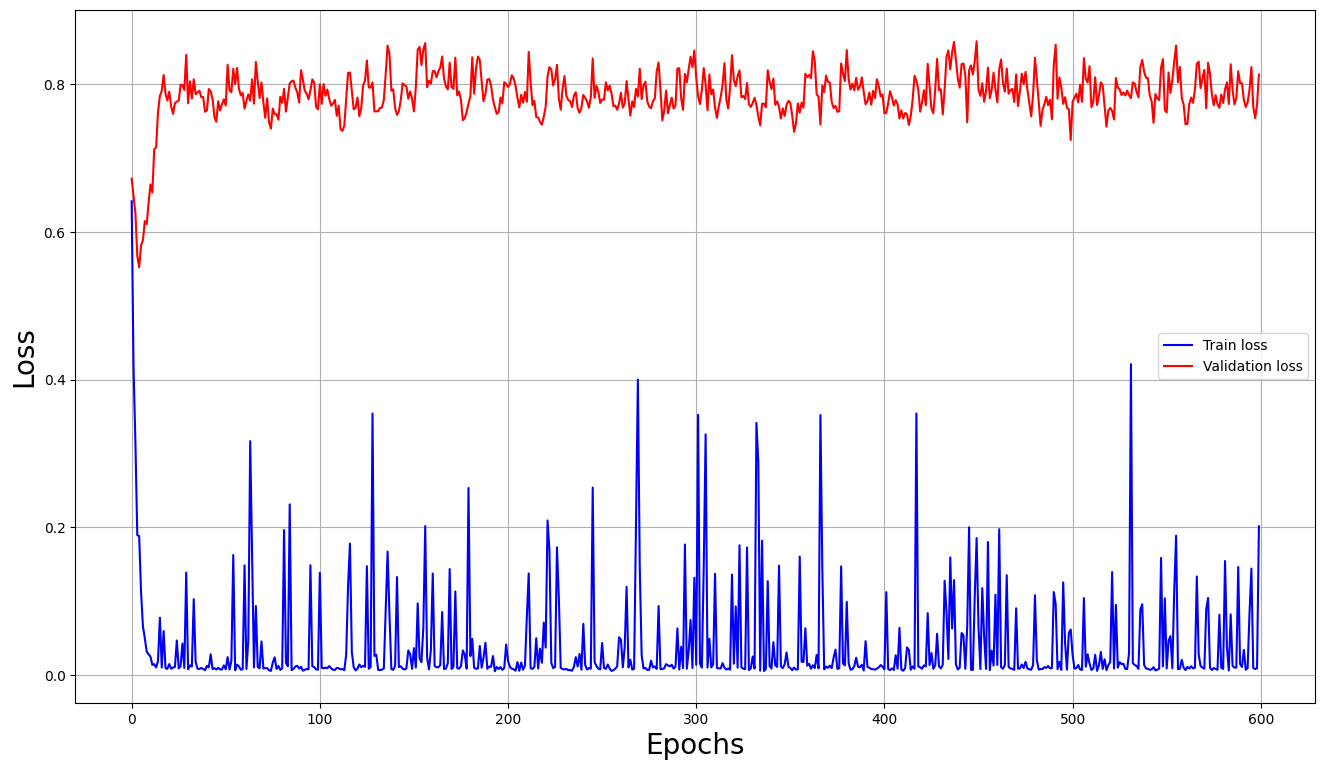

In [64]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)


As seen in the ResNet50, the loss here is also stable around 0.8, but still shows no improvement.

## EfficientNet
We attempt a different pretrained model to see whether it could change the prior results in any way. EfficientNet is known for its performance in medical imaging tasks. We go for EfficienNetB0 as it is not too heavy in terms of parameters but still provides good performance.

In [66]:
class EfficientNetB0Model(nn.Module):
    def __init__(self):
        super(EfficientNetB0Model, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        # Replace the final fully connected layer
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.efficientnet(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNetB0Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Use BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()

In [67]:
num_epochs = 600
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    mri_dataset.mode = 'train'
    
    for D in train_dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        loss = criterion(y_hat.squeeze(), label)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    model.eval()
    val_losses = []
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            loss = criterion(y_hat.squeeze(), label)
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    scheduler.step(epoch_val_loss[-1])
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss[-1]:.6f}, Val Loss: {epoch_val_loss[-1]:.6f}')

Epoch 10, Train Loss: 0.270929, Val Loss: 0.472362
Epoch 20, Train Loss: 0.243760, Val Loss: 0.508558
Epoch 30, Train Loss: 0.120480, Val Loss: 0.528654
Epoch 40, Train Loss: 0.103076, Val Loss: 0.558160
Epoch 50, Train Loss: 0.070340, Val Loss: 0.540034
Epoch 60, Train Loss: 0.067691, Val Loss: 0.504132
Epoch 70, Train Loss: 0.071102, Val Loss: 0.554593
Epoch 80, Train Loss: 0.070069, Val Loss: 0.522057
Epoch 90, Train Loss: 0.066114, Val Loss: 0.507118
Epoch 100, Train Loss: 0.078684, Val Loss: 0.542440
Epoch 110, Train Loss: 0.067741, Val Loss: 0.518640
Epoch 120, Train Loss: 0.072920, Val Loss: 0.549638
Epoch 130, Train Loss: 0.069888, Val Loss: 0.509289
Epoch 140, Train Loss: 0.056375, Val Loss: 0.527256
Epoch 150, Train Loss: 0.065858, Val Loss: 0.527028
Epoch 160, Train Loss: 0.186256, Val Loss: 0.515076
Epoch 170, Train Loss: 0.119566, Val Loss: 0.527588
Epoch 180, Train Loss: 0.133092, Val Loss: 0.501318
Epoch 190, Train Loss: 0.109029, Val Loss: 0.551704
Epoch 200, Train Loss

Text(0, 0.5, 'Loss')

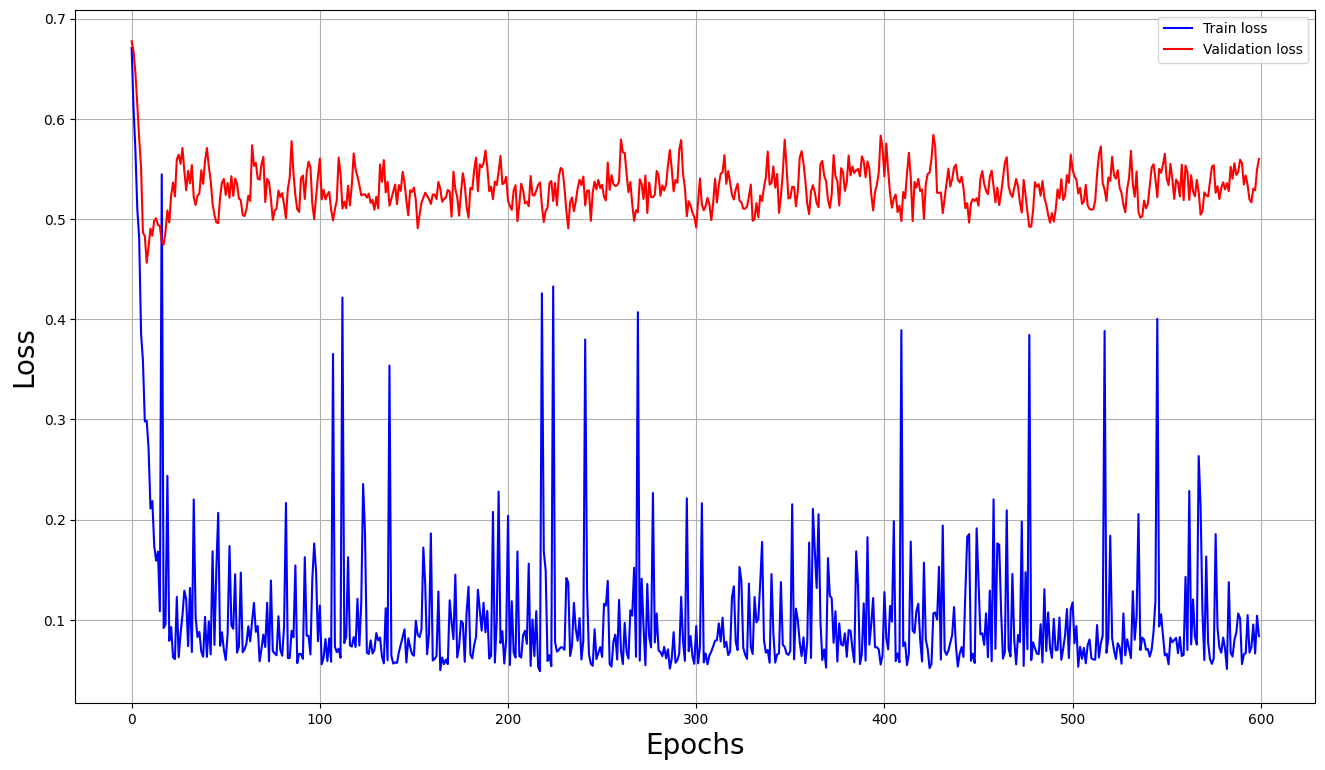

In [69]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)

EfficientNetB0 has shown improvement in the validation loss from 0.8 to around 0.5. Although this shows the model is better suited to this task than the ResNets, the validation loss is still too high and the EfficientNet could not mitigate the overfitting problem. After numerous different attempts, the issue of overfitting may be attributed to dataset size. In future work, the dataset size should be increased. Although data augmentation is not such a handy tool in medical image datasets, as distorting images in any way could result in incorrect representations and thus, bad training, attempts could be made to gather more real data and augmentation techniques that do not deform the 